# Step 0: Mounts and Imports

In [1]:
# Mounting Google Drive
from google.colab import drive, output, files
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Note: The extension ipympl enables interactive features for matplotlib
!pip install -q ipympl
get_ipython().kernel.do_shutdown(restart=True)

from google.colab import output
output.enable_custom_widget_manager()

%matplotlib ipympl

In [1]:
# Main Imports
import scipy.io as sio
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # Used to create confusion heatmaps
import os                       # Used to convert between dataframe and csv
import pywt                     # Used to perform wavelet transform

# Classifier imports
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

In [2]:
# Utils import
!cp /content/drive/MyDrive/Grasp\ Project\ /Data\ /Our\ Model\ [External\ Data\ Analysis/utils_babyscript.py /content
import utils_babyscript as ut

import importlib
importlib.reload(ut)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'utils_babyscript' from '/content/utils_babyscript.py'>

In [3]:
labels = {1: 'Large Diameter Grasp', 2: 'Small Diameter Grasp (power grip)',
          3: 'Fixed Hook Grasp', 4: 'Index Finger Extension Grasp', 5:
          'Medium Wrap', 6: 'Ring Grasp', 7: 'Prismatic Four Fingers Grasp',
          8: 'Stick Grasp', 9: 'Writing Tripod Grasp', 10: 'Power Sphere Grasp',
          11: 'Three Finger Sphere Grasp', 12: 'Precision Sphere Grasp', 13:
          'Tripod Grasp', 14: 'Prismatic Pinch Grasp', 15: 'Tip Pinch Grasp',
          16: 'Quadpod Grasp', 17: 'Lateral Grasp', 18: 'Parallel Extension Grasp',
          19: 'Extension Type Grasp', 20: 'Power Disk Grasp', 21: 'Open a Bottle with a Tripod Grasp',
          22: 'Turn a Screw', 23: 'Cut Something'}

# Step 2: Process Subject 1 kinematic data.

In [42]:
# Loads MATLAB file for Subject 1
subject1_file_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1/Subject_1/S1_A1_E3.mat'
subject1_file_dict = sio.loadmat(subject1_file_path)

In [43]:
# Process kinematic data for subject 1 by converting it to a Pandas dataframe
'''
Note: Kinematic data in Ninapro DB1 was originally sampled at 25 Hz, but it was
linearly interpolated to match the 100 Hz EMG signal. The process_ninapro_subject
function uses sampling rate to add a time column to the dataframe, which is why
I am using a sampling rate of 100 Hz here.
'''
sampling_rate = 100
subject1_kinematic_dataframe, _ = ut.process_ninapro_subject(subject1_file_path,
                                                             sampling_rate)

In [44]:
# Filter data using a 6 Hz low-pass butterworth filter on a data singal.
kinematic_sampling_rate = 25
subject1_filtered_kin_dataframe = ut.filter_data(subject1_kinematic_dataframe,
                                                 kinematic_sampling_rate,
                                                'kinematics')

In [45]:
'''
normalize_kinematic_data(filtered_dataframe)

Purpose: Normalize kinematic data based on maximum/minimum joint extension.
Parameters: filtered kinematic data (Pandas dataframe)
Output: Normalized kinematic data (Pandas dataframe)
'''

def normalize_kinematic_data(filtered_dataframe):
  normalized_dataframe = pd.DataFrame(index=filtered_dataframe.index)
  for column in filtered_dataframe.columns:
    if column == 'Time':
      normalized_dataframe[column] = filtered_dataframe[column]
      continue
    column_min = filtered_dataframe[column].min()
    column_max = filtered_dataframe[column].max()
    if column_min == column_max:
      normalized_dataframe[column] = 0
    else:
      normalized_dataframe[column] = (filtered_dataframe[column] - column_min) / (column_max - column_min)
  return normalized_dataframe


In [46]:
# Normalize kinematic data based on maximum/minumum joint extension
subject1_normalized_kin_dataframe = normalize_kinematic_data(subject1_filtered_kin_dataframe)

In [47]:
# Segment the data based on restimulus file. Results in a list of dataframes.
subject1_restimulus_data = subject1_file_dict['restimulus']
restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject1_restimulus_data)
subject1_kinematic_trials = ut.segment_data(subject1_normalized_kin_dataframe, restim_timestamps)

# Segmentation based on stimulus data (for visualization only)
subject1_stimulus_data = subject1_file_dict['stimulus']
stim_timestamps, stim_labels = ut.gather_restim_timestamps_and_labels(subject1_stimulus_data)
subject1_kinematic_trials_stim = ut.segment_data(subject1_normalized_kin_dataframe, stim_timestamps)

Visualization of fully processed kinematic data for one grasp type:

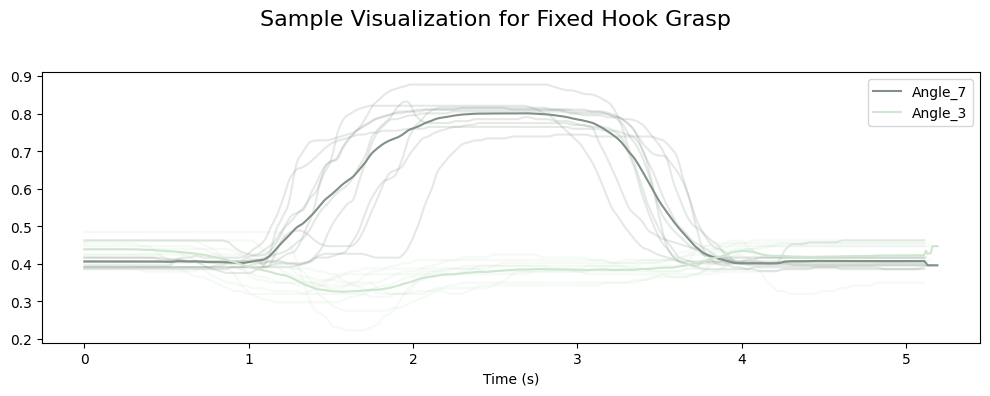

In [48]:
ut.visualize_full_grasp(subject1_kinematic_trials_stim, 3, ['Angle_7', 'Angle_3'])

# Step 3: Extract features from Subject 1 kinematic data.

In [49]:
'''
get_kinematic_features(kinematic_data)

Purpose: Extract basic statistical and dynamic kinematic features for each
joint measured by the Cyberglove II system.
Parameters: segmented kinematic data (list of Pandas dataframes)
Output: List of kinematic features for each trial (2D list). Each joint
contributes a mean, std, range, median, iqr, mean velocity, and std velocity
feature to that trial.
'''
def get_kinematic_features(kinematic_data):
  results = []

  for trial in kinematic_data:
    trial_features = []
    for column in trial.columns:
      if column == 'Time':
        continue
      else:

        # Standard extracted features: mean, standard deviation, range, median, iqr
        mean = float(np.mean(trial[column]))
        std = np.std(trial[column])
        range = np.max(trial[column]) - np.min(trial[column])
        median = float(np.median(trial[column]))
        q1, q3 = np.percentile(trial[column], [25, 75])
        iqr = float(q3 - q1)

        # Dynamic extracted features: mean velocity, std. velocity
        velocities = np.diff(trial[column])
        mean_velocity = float(np.mean(velocities))
        std_velocity = float(np.std(velocities))

        trial_features.extend([mean, std, range, median, iqr, mean_velocity, std_velocity])
    results.append(trial_features)
  return results

In [ ]:
# Based on the results of the ML model, determine what the best features are to keep and which I should get rid of.

In [50]:
subject1_kinematic_features = get_kinematic_features(subject1_kinematic_trials)

# Step 4: Create a simple ML model for Subject 1.

In [51]:
# Define x (features) and y (labels).
x = subject1_kinematic_features
y = restim_labels

In [52]:
# Split the kinematic data into test and training groups using an 80/20 data split.

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2,
                                                                    random_state=0)

In [53]:
# Scale features.
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Here, I used RFECV to determine the optimal number of features for the ML model. However, after testing the new optimal training and test sets, I received lower accuracy.

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

selector = RFECV(estimator=model, step=10, cv=StratifiedKFold(5), scoring='accuracy')
selector = selector.fit(x_train, y_train)

X_train_rfe = selector.transform(x_train)
X_test_rfe = selector.transform(x_test)

print(f"Optimal number of features: {selector.n_features_}")

'''
Optimal number of features: 144
'''

I also experimented with PCA on the dataset. Again, I received a lower accuracy with the PCA training and test sets compared to the original.

In [ ]:
# PCA  with 144 features

pca = PCA(n_components=144)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print(f"Shape of training data after PCA: {x_train_pca.shape}")
print(f"Shape of test data after PCA: {x_test_pca.shape}")


Shape of training data after PCA: (184, 144)
Shape of test data after PCA: (46, 144)


Note how the accuracy is at its highest when all of the original features are not used, without PCA. So I will keep all kinematic features.

In [54]:
# Random Forest Classifier
random_forest_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                             criterion='gini', max_depth=None, max_features='sqrt',
                                             max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                             min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                             monotonic_cst=None, n_estimators=100, n_jobs=None, oob_score=False,
                                             random_state=None, verbose=0, warm_start=False)
random_forest_model.fit(x_train, y_train)

# Test the accuracy of the model.
y_predicted = random_forest_model.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)

# Gets parameters of the model if it is accurate
print(f'Random Forest Accuracy: {accuracy}')
if accuracy >= 0.95:
  params = random_forest_model.get_params()
  print('Successful RF Parameters:')
  print(params)

Random Forest Accuracy: 0.9782608695652174
Successful RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Step 6: Combine the kinematic data for all participants.

In [19]:
# Create a list of folders with all Ninapro DB1 subjects
ninaproDB1_folder_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1'
subject_folders = os.listdir(ninaproDB1_folder_path)

In [57]:
'''
get_kinematic_features_and_labels(subject_folders)

Purpose: Gets all the kinematic features and labels for one subject.
Parameters: subject folder path (str)
Output: kinematic features (2D list) and labels (1D list)
'''
def get_kinematic_features_and_labels(subject_folder):

  # Get path for folder
  subject_folder_path = os.path.join(ninaproDB1_folder_path, subject_folder)

  # Find data path for correct file using subject number
  subject_number = ut.find_subject_number(subject_folder)
  subject_data_path = subject_folder_path + f'/S{subject_number}_A1_E3.mat'
  print(f'Processing Subject #{subject_number}...')

  # Extract and filter kinematic data from file
  subject_kinematic_data, _ = ut.process_ninapro_subject(subject_data_path, 100)
  subject_filtered_kinematic_data = ut.filter_data(subject_kinematic_data, 25, 'kinematics')

  # Normalize data
  subject_normalized_kinematic_data = normalize_kinematic_data(subject_filtered_kinematic_data)

  # Segment data
  subject_restimulus_data = sio.loadmat(subject_data_path)['restimulus']
  restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject_restimulus_data)
  subject_kinematic_trials = ut.segment_data(subject_normalized_kinematic_data, restim_timestamps)

  # Extract kinematic featuers
  subject_kinematic_features = get_kinematic_features(subject_kinematic_trials)

  return subject_kinematic_features, restim_labels

In [58]:
def process_all_subjects_kinematic(folder_list):
  all_kinematic_features = []
  all_labels = []

  for folder in folder_list:
    # Skip saved csv files and outliers
    if folder in ['all_kinematic_features.csv', 'all_emg_features.csv',
                  'all_kinematic_labels.csv', 'all_combined_features.csv',
                  'Subject_27']:
      continue
    else:
      # Get features
      subject_kinematic_features, subject_labels = get_kinematic_features_and_labels(folder)
      all_kinematic_features.extend(subject_kinematic_features)
      all_labels.extend(subject_labels)
    print('Done!')
  return all_kinematic_features, all_labels

all_kinematic_features, all_labels = process_all_subjects_kinematic(subject_folders)


Processing Subject #1...
Processing Subject #2...
Processing Subject #3...
Processing Subject #4...
Processing Subject #5...
Processing Subject #6...
Processing Subject #7...
Processing Subject #8...
Processing Subject #9...
Processing Subject #10...
Processing Subject #11...
Processing Subject #12...
Processing Subject #13...
Processing Subject #14...
Processing Subject #15...
Processing Subject #16...
Processing Subject #17...
Processing Subject #18...
Processing Subject #19...
Processing Subject #20...
Processing Subject #21...
Processing Subject #22...
Processing Subject #23...
Processing Subject #24...
Processing Subject #25...
Processing Subject #26...


In [59]:
# This takes a long time to process! Here I will save the results as a csv.
ut.features_to_csv(all_kinematic_features, 'all_kinematic_features.csv')
ut.features_to_csv(all_labels, 'all_kinematic_labels.csv')

In [60]:
# Converts csv files back into useable features data
all_kinematic_features = ut.csv_to_features('all_kinematic_features.csv')
all_labels = ut.csv_to_features('all_kinematic_labels.csv')

# Step 7: Train new Random Forest classifier with full Kinematic database.

In [69]:
# Define x (features) and y (labels)
x = all_kinematic_features
y = all_labels

In [87]:
# Split into test and training groups. Will use an 80/20 split.
trials_per_subject = 230

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=trials_per_subject,
                                                                    random_state=0)

In [88]:
# Scale the data.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)`

In [109]:
# Create a basic random forest classifier.
full_random_forest_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
                                                  max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                                                  max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                                                  min_samples_split=2, min_weight_fraction_leaf=0.0, monotonic_cst=None,
                                                  n_estimators = 100, n_jobs=None, oob_score=False, random_state=None,
                                                  verbose=0, warm_start=False)
full_random_forest_model.fit(x_train_scaled, y_train)

'''
class_weight='balanced', max_depth=30,
                            max_features='log2', min_samples_leaf=5,
                            n_estimators=200, random_state=42
'''

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


"\nclass_weight='balanced', max_depth=30,\n                            max_features='log2', min_samples_leaf=5,\n                            n_estimators=200, random_state=42\n"

In [110]:
# Test the accuracy of the model
y_predicted = full_random_forest_model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_predicted)

print(f'Random Forest Accuracy: {accuracy}')
# Gets paramaters of model if its accurate
if accuracy >= 0.90:
  params = full_random_forest_model.get_params()
  print('Successful RF Parameters:')
  print(params)

Random Forest Accuracy: 0.9521739130434783
Successful RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


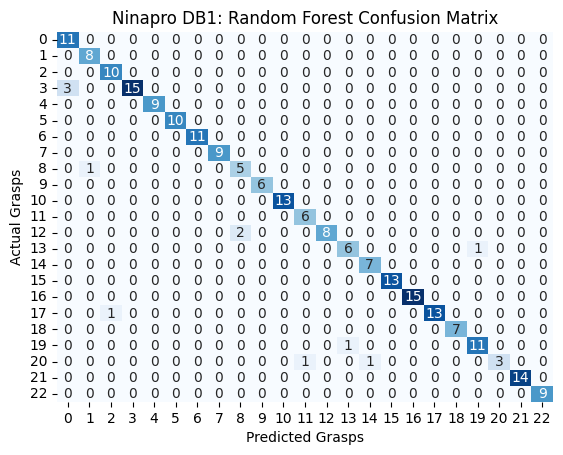

In [111]:
# Visualizing the confusion matrix with a Seaborn heatmap
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Grasps')
plt.ylabel('Actual Grasps')
plt.title('Ninapro DB1: Random Forest Confusion Matrix')
plt.show()

# Step 8: Analysis of Kinematic model with PCA and Group K Fold.

In [112]:
#Use GroupKFold to simulate each subject being used as a member of the study. Display results in a table that is easy to understand.

from sklearn.model_selection import GroupKFold

# Create the 'groups' array. Each element corresponds to a trial and indicates
# which subject the trial belongs to.
num_subjects = len(all_kinematic_features) // trials_per_subject
groups = np.repeat(range(num_subjects), trials_per_subject)

# Initialize GroupKFold
group_kfold = GroupKFold(n_splits=num_subjects)

# Initialize a list to store results for each fold
results = []

# Perform GroupKFold cross-validation
fold_number = 1
for train_index, test_index in group_kfold.split(all_kinematic_features, all_labels, groups):
    X_train, X_test = [all_kinematic_features[i] for i in train_index], [all_kinematic_features[i] for i in test_index]
    y_train, y_test = [all_labels[i] for i in train_index], [all_labels[i] for i in test_index]

    # Convert lists to numpy arrays for scaling and modeling
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train the Random Forest classifier (using the same parameters as before)
    model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
                                                  max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                                                  max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                                                  min_samples_split=2, min_weight_fraction_leaf=0.0, monotonic_cst=None,
                                                  n_estimators = 100, n_jobs=None, oob_score=False, random_state=None,
                                                  verbose=0, warm_start=False)
    model.fit(X_train_scaled, y_train)

    # Test the accuracy of the model
    y_predicted = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_predicted)

    # Determine which subject was in the test set for this fold
    # The group for the first element in the test index is the subject number (0-indexed)
    test_subject_index = groups[test_index[0]]
    test_subject_number = test_subject_index + 1 # Convert to 1-indexed subject number

    results.append({
        'Fold': fold_number,
        'Test Subject': f'Subject {test_subject_number}',
        'Accuracy': accuracy
    })

    fold_number += 1

# Display results in a pandas DataFrame
results_df = pd.DataFrame(results)
print("\nGroupKFold Cross-Validation Results (Leave-One-Subject-Out):")
results_df

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi


GroupKFold Cross-Validation Results (Leave-One-Subject-Out):


,Fold,Test Subject,Accuracy
0,1,Subject 26,0.595652
1,2,Subject 25,0.847826
2,3,Subject 24,0.817391
3,4,Subject 23,0.673913
4,5,Subject 22,0.821739
5,6,Subject 21,0.826087
6,7,Subject 20,0.826087
7,8,Subject 19,0.865217
8,9,Subject 18,0.808696
9,10,Subject 17,0.756522


In [119]:
# Median subject-by-subject accuracy:
median_accuracy = results_df['Accuracy'].median()
print(f"\nMedian Subject-by-Subject Accuracy: {median_accuracy}")


Median Subject-by-Subject Accuracy: 0.7869565217391304


In [114]:
subject_info = {
    1: ["Right", "Male", 31, 170, 75],
    2: ["Right", "Male", 27, 170, 62],
    3: ["Right", "Male", 22, 180, 85],
    4: ["Right", "Male", 27, 183, 95],
    5: ["Right", "Male", 27, 178, 75],
    6: ["Right", "Female", 22, 163, 48],
    7: ["Right", "Male", 28, 170, 60],
    8: ["Right", "Female", 27, 164, 54],
    9: ["Right", "Male", 23, 173, 63],
    10: ["Right", "Female", 30, 160, 60],
    11: ["Right", "Male", 28, 170, 67],
    12: ["Right", "Male", 25, 185, 80],
    13: ["Right", "Male", 27, 184, 85],
    14: ["Left", "Female", 29, 155, 54],
    15: ["Right", "Female", 26, 162, 60],
    16: ["Left", "Male", 29, 167, 67],
    17: ["Right", "Male", 30, 175, 76],
    18: ["Right", "Male", 29, 178, 68],
    19: ["Right", "Male", 34, 173, 82],
    20: ["Right", "Female", 26, 165, 54],
    21: ["Right", "Male", 38, 178, 73],
    22: ["Right", "Female", 35, 168, 65],
    23: ["Right", "Male", 30, 180, 65],
    24: ["Right", "Male", 26, 180, 65],
    25: ["Right", "Male", 28, 180, 70],
    26: ["Right", "Male", 40, 179, 66],
}

In [115]:
# Based on the subject info and group k fold analysis, determine and clearly display any trends in accuracy based on handedness, gender, age, height, and weight.

# Augment results_df with subject information
results_df['Handedness'] = results_df['Test Subject'].apply(lambda x: subject_info[int(x.split(' ')[1])][0])
results_df['Gender'] = results_df['Test Subject'].apply(lambda x: subject_info[int(x.split(' ')[1])][1])
results_df['Age'] = results_df['Test Subject'].apply(lambda x: subject_info[int(x.split(' ')[1])][2])
results_df['Height'] = results_df['Test Subject'].apply(lambda x: subject_info[int(x.split(' ')[1])][3])
results_df['Weight'] = results_df['Test Subject'].apply(lambda x: subject_info[int(x.split(' ')[1])][4])

# Handedness
print("\nAccuracy by Handedness:")
handedness_trend = results_df.groupby('Handedness')['Accuracy'].mean().reset_index()
print(handedness_trend)

# Gender
print("\nAccuracy by Gender:")
gender_trend = results_df.groupby('Gender')['Accuracy'].mean().reset_index()
print(gender_trend)

# Age (can look at correlation or group into bins)
print("\nCorrelation between Accuracy and Age:")
age_corr = results_df['Accuracy'].corr(results_df['Age'])
print(f"Correlation Coefficient: {age_corr:.4f}")
# Group age into bins for clearer trend visualization
results_df['Age_Group'] = pd.cut(results_df['Age'], bins=[20, 30, 40, 50], right=False, labels=['20-29', '30-39', '40+'])
print("\nAccuracy by Age Group:")
age_group_trend = results_df.groupby('Age_Group')['Accuracy'].mean().reset_index()
print(age_group_trend)

# Height (can look at correlation or group into bins)
print("\nCorrelation between Accuracy and Height:")
height_corr = results_df['Accuracy'].corr(results_df['Height'])
print(f"Correlation Coefficient: {height_corr:.4f}")
#  Group height into bins
results_df['Height_Group'] = pd.cut(results_df['Height'], bins=[150, 160, 170, 180, 190], right=False, labels=['150-159', '160-169', '170-179', '180+'])
print("\nAccuracy by Height Group:")
height_group_trend = results_df.groupby('Height_Group')['Accuracy'].mean().reset_index()
print(height_group_trend)


# Weight (can look at correlation or group into bins)
print("\nCorrelation between Accuracy and Weight:")
weight_corr = results_df['Accuracy'].corr(results_df['Weight'])
print(f"Correlation Coefficient: {weight_corr:.4f}")
# Group weight into bins
results_df['Weight_Group'] = pd.cut(results_df['Weight'], bins=[40, 50, 60, 70, 80, 90, 100], right=False, labels=['40-49', '50-59', '60-69', '70-79', '80-89', '90+'])
print("\nAccuracy by Weight Group:")
weight_group_trend = results_df.groupby('Weight_Group')['Accuracy'].mean().reset_index()
print(weight_group_trend)


Accuracy by Handedness:
  Handedness  Accuracy
0       Left  0.839130
1      Right  0.761775

Accuracy by Gender:
   Gender  Accuracy
0  Female  0.791304
1    Male  0.759039

Correlation between Accuracy and Age:
Correlation Coefficient: -0.0542

Accuracy by Age Group:
  Age_Group  Accuracy
0     20-29  0.771981
1     30-39  0.781366
2       40+  0.595652

Correlation between Accuracy and Height:
Correlation Coefficient: -0.3938

Accuracy by Height Group:
  Height_Group  Accuracy
0      150-159  0.856522
1      160-169  0.786335
2      170-179  0.768775
3         180+  0.734783

Correlation between Accuracy and Weight:
Correlation Coefficient: -0.3094

Accuracy by Weight Group:
  Weight_Group  Accuracy
0        40-49  0.756522
1        50-59  0.823188
2        60-69  0.761957
3        70-79  0.784348
4        80-89  0.765217
5          90+  0.608696


/tmp/ipython-input-115-2759035228.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_trend = results_df.groupby('Age_Group')['Accuracy'].mean().reset_index()
/tmp/ipython-input-115-2759035228.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_group_trend = results_df.groupby('Height_Group')['Accuracy'].mean().reset_index()
/tmp/ipython-input-115-2759035228.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

Again, applying PCA to the kinematic data decreased the overall accuracy of the model.

Number of features before PCA (Full Dataset): 154
Number of features after PCA (Full Dataset): 130


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy with PCA (Full Dataset): 0.04782608695652174
Difference in accuracy (Full Dataset): -0.7478260869565216


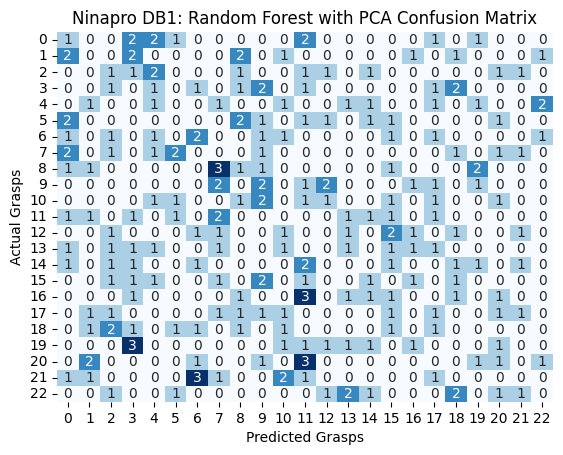

In [117]:
# Apply PCA in the same exact way as the smaller model, then evaluate performance

# Apply PCA to the full dataset
pca_full = PCA(n_components=130) # Using the same number of components as the smaller model example
x_train_scaled_pca = pca_full.fit_transform(x_train_scaled)
x_test_scaled_pca = pca_full.transform(x_test_scaled)

print(f"Number of features before PCA (Full Dataset): {x_train_scaled.shape[1]}")
print(f"Number of features after PCA (Full Dataset): {x_train_scaled_pca.shape[1]}")

# Train a new Random Forest model with PCA-transformed full dataset
full_random_forest_model_pca = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini',
                                                  max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                                                  max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                                                  min_samples_split=2, min_weight_fraction_leaf=0.0, monotonic_cst=None,
                                                  n_estimators = 100, n_jobs=None, oob_score=False, random_state=None,
                                                  verbose=0, warm_start=False) # Using the same parameters as the original full model
full_random_forest_model_pca.fit(x_train_scaled_pca, y_train)

# Evaluate the accuracy of the PCA-based full model
y_predicted_pca_full = full_random_forest_model_pca.predict(x_test_scaled_pca)
accuracy_pca_full = accuracy_score(y_test, y_predicted_pca_full)

print(f'Random Forest Accuracy with PCA (Full Dataset): {accuracy_pca_full}')
print(f'Difference in accuracy (Full Dataset): {accuracy_pca_full - accuracy}')

# Visualize the confusion matrix for the PCA-based full model
sns.heatmap(confusion_matrix(y_test, y_predicted_pca_full), annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted Grasps')
plt.ylabel('Actual Grasps')
plt.title('Ninapro DB1: Random Forest with PCA Confusion Matrix')
plt.show()